# SIGNAL PROCESSING PROJECT - M2 AI
## Audio Declipping with Social Sparsity

- Benedictus Kent Rachmat
- Jacobo Ruiz Ocampo

[paper link](https://hal.science/hal-01002998/document)

---

## IMPORT

In [6]:
import numpy as np 
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.optimize import fsolve

In [7]:
def snr(signal_original, signal_processed):
    """computes the SNR

    Args:
        signal_original (ndarray): the original signal
        signal_processed (ndarray): the processed signal (clipped, declipped...etc)

    Returns:
        float: the SNR
    """
    return 20 * np.log10(
        np.linalg.norm(signal_original) / np.linalg.norm(signal_original - signal_processed)
    )

In [8]:
def compute_snr(signal, noise, masks=1): 
    """
    Computes the Signal-to-Noise Ratio (SNR) for a given signal and noise.
    ----------
    :param signal: The original signal.
    :param noise: The noise in the signal.
    :param masks: Masks to apply to the signal and noise.
    :returns: The calculated SNR.
    """
    return 20 * np.log10(np.linalg.norm(masks * signal) / np.linalg.norm(masks * noise))

def threshold_clip(audio_signal, amplitude_threshold): 
    """
    Clips an audio signal to a specified amplitude threshold.
    ----------
    :param audio_signal: The audio signal to be clipped.
    :param amplitude_threshold: The threshold for clipping the amplitude.
    :returns: (the clipped audio, the mask indicating where the signal was clipped)
    """
    lower_limit, upper_limit = -amplitude_threshold, amplitude_threshold
    mask_info = (audio_signal > upper_limit) | (audio_signal < lower_limit)

    clipped_signal = np.clip(audio_signal, lower_limit, upper_limit)

    return clipped_signal, mask_info

def snr_based_clip(audio_signal, target_snr): 
    """
    Clips an audio signal based on a target Signal-to-Noise Ratio (SNR).
    ----------
    :param audio_signal: The audio signal to be clipped.
    :param target_snr: The target SNR in decibels.
    :returns: 
            - Clipped signal
            - The mask indicating where the signal was clipped
            - The amplitude threshold
    """
    amplitude_threshold = fsolve(lambda T: compute_snr(audio_signal, audio_signal - threshold_clip(audio_signal, T)[0]) - target_snr, 0)[0]
    clipped_signal, masks = threshold_clip(audio_signal, amplitude_threshold)
    return clipped_signal, masks, amplitude_threshold

We load `music.wav` and implement audio clipping controlled by the Signal-to-Noise Ratio (SNR). The `snr_based_clip` function adjusts the clipping level of an audio signal to achieve a specified SNR target. First, it determines the appropriate amplitude threshold needed to reach the desired SNR. This is achieved using the fsolve function, which finds the root of the equation where the computed SNR of the clipped signal equals the target SNR. The SNR is calculated using the formula: 
$$ \text{SNR} = 20 \times \log_{10}\left(\frac{\|\text{signal} \|}{\| \text{noise} \|}\right) $$
where `signal` is the original audio signal, and `noise` is the difference between the original and clipped signals. After finding the amplitude threshold, the function applies threshold clipping to the audio signal.

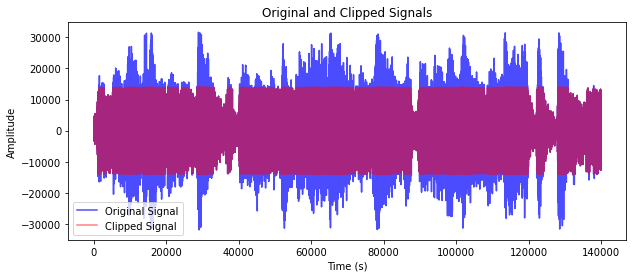

In [10]:
sampling_rate, audio_data = wavfile.read("music.wav")
length_data = len(audio_data)
target_snr = 15

clipped_data, clipping_masks, clip_threshold = snr_based_clip(audio_data, target_snr)

plt.figure(figsize=(10, 4))
plt.title("Original and Clipped Signals")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.plot(audio_data, label="Original Signal", color="blue", alpha=0.7)
plt.plot(clipped_data, label="Clipped Signal", color="red", alpha=0.5)
plt.legend()
plt.show()

Audio(clipped_data, rate=sampling_rate)

## Implementing the 4 thresholding strategies for the convex optimization problem

The paper mentioned 4 shrinkage operators as follows: 

#### Lasso Method
This approach alters the time-frequency coefficients $\alpha_{tf}$ using a Lasso-inspired formula. The formula is:
$$\tilde{\alpha}{tf} = \alpha{tf} (1 - \frac{\lambda}{|\alpha_{tf}|})^{+}$$

Here, the Lasso shrinkage is applied to each coefficient independently.

#### Windowed Group-Lasso (WGL)
This method extends the Lasso approach by considering the local neighborhood of each time-frequency coefficient. The formula is:
$$\tilde{\alpha}{tf} = \alpha{tf} (1 - \frac{\lambda}{\sqrt{\sum_{t' \in \mathcal{N}(t)} |\alpha_{t'f}|^2}})^{+}$$
It takes into account the energy of coefficients in a specified neighborhood, promoting group sparsity.

#### Empirical Wiener (EW)
In this approach, the coefficients are adjusted using an empirical Wiener-like method. The formula is:
$$\tilde{\alpha}{tf} = \alpha{tf} (1 - \frac{\lambda^2}{|\alpha_{tf}|^2})^{+}$$
This method applies a squared ratio for the shrinkage, differing from the Lasso method.

#### Persistent Empirical Wiener (PEW)
Similar to EW, this method also uses a Wiener-like approach but includes neighborhood considerations. The formula is:
$$\tilde{\alpha}{tf} = \alpha{tf} (1 - \frac{\lambda^2}{\sum_{t' \in \mathcal{N}(t)} |\alpha_{t'f}|^2})^{+}$$
It computes the ratio based on the sum of squared coefficients in a local neighborhood, encouraging a persistent sparsity pattern.

Where:
- $\tilde{\alpha}{tf}$: the adjusted coefficient
- $\alpha{tf}$: the original coefficient
- $\lambda$: a threshold parameter
- $\mathcal{N}(t)$: the neighborhood of time index $t$
- The subscript $+$: the operation inside the parenthesis is clipped at zero

Before implementing the methods, we need to be able to compute the time-frequency neighborhood systems that WGL and PEW use to exploit persistency properties of the signal.

In [18]:
def compute_neighborhood(alpha, size):
    """
    Computes the neighborhood of squared alpha values using convolution.
    ----------
    :param alpha: The input alpha values.
    :param size: The size of the neighborhood kernel.
    :returns: The convolved result representing the neighborhood.
    """
    kernel = np.full((size, 1), fill_value=1/size)
    
    # Compute squared alpha values
    squared_alpha = np.square(np.abs(alpha))
    
    # Convolve squared alpha with the kernel
    convolved_result = signal.convolve2d(squared_alpha, kernel, boundary='symm', mode="same")
    return convolved_result

In [19]:
def lasso(alpha, lamda, size=None):
    """
    Applies Lasso shrinkage operator to alpha.
    ----------
    :param alpha: The input alpha values.
    :param lamda: The threshold parameter for Lasso shrinkage.
    :param size: Size parameter (not used).
    :returns: The result of Lasso shrinkage on alpha.
    """
    return alpha * (1 - lamda / np.abs(alpha)).clip(min=0)


def wgl(alpha, lamda, size=None):
    """
    Applies Weighted Group Lasso (WGL) shrinkage operator to alpha.
    ----------
    :param alpha: The input alpha values.
    :param lamda: The threshold parameter for WGL shrinkage.
    :param size: The size parameter for computing the neighborhood.
    :returns: The result of WGL shrinkage on alpha.
    """
    return alpha * (1 - lamda / np.sqrt(compute_neighborhood(alpha, size))).clip(min=0)


def ew(alpha, lamda, size=None):
    """
    Applies Exponential Weighted (EW) shrinkage operator to alpha.
    ----------
    :param alpha: The input alpha values.
    :param lamda: The threshold parameter for EW shrinkage.
    :param size: Size parameter (not used).
    :returns: The result of EW shrinkage on alpha.
    """
    return alpha * (1 - (lamda / np.abs(alpha)) ** 2).clip(min=0)


def pew(alpha, lamda, size=None):
    """
    Applies Partial Exponential Weighted (PEW) shrinkage operator to alpha.
    ----------
    :param alpha: The input alpha values.
    :param lamda: The threshold parameter for PEW shrinkage.
    :param size: The size parameter for computing the neighborhood.
    :returns: The result of PEW shrinkage on alpha.
    """
    return alpha * (1 - lamda**2 / compute_neighborhood(alpha, size)).clip(min=0)

Our time-frequency dictionnary used for our time frequency dictionnary will be a tight Gabor frame, and as in the paper,  we employ it is based on a Hann window of `1024` samples (defined as tight) . As stated in the paper our analysis operator must be the correponding Short Time-Fourier Transform. The time-shift parameter is set to `256` samples and window length of `1024`

In [20]:
class Gabor:
    def __init__(self, rate, length_data):
        self.rate = rate
        self.window_type = 'hann'
        self.window_length = 1024   
        self.time_shift = 256      
        self.nfft = 2 * self.window_length   
        self.length = length_data

    def analysis_op(self, audio_signal):
        """Performs Short-Time Fourier Transform using a Hann window."""
        _, _, Zxx = signal.stft(
            audio_signal, 
            fs=self.rate, 
            window=self.window_type, 
            nperseg=self.window_length, 
            noverlap=self.window_length - self.time_shift, 
            nfft=self.nfft
        )
        return Zxx

    def synthesis_op(self, Zxx):
        """Performs Inverse Short-Time Fourier Transform."""
        _, audio_signal = signal.istft(
            Zxx, 
            fs=self.rate, 
            window=self.window_type, 
            nperseg=self.window_length, 
            noverlap=self.window_length - self.time_shift, 
            nfft=self.nfft
        )
        return audio_signal[:self.length]

We build our Gabor frame that we will be using for our algorithm:

In [21]:
gab = Gabor(sampling_rate, length_data)

In [22]:
for lambda_param in (np.logspace(-1, -4, 10)):
    print(lambda_param)

0.1
0.046415888336127795
0.021544346900318846
0.01
0.004641588833612782
0.0021544346900318843
0.001
0.0004641588833612782
0.00021544346900318845
0.0001


In [23]:
for lambda_param in (np.logspace(1, -4, 10)):
    print(lambda_param)

10.0
2.7825594022071245
0.774263682681127
0.21544346900318834
0.05994842503189409
0.016681005372000592
0.004641588833612777
0.0012915496650148827
0.00035938136638046257
0.0001


## Relaxed version of ISTA

In [29]:
def declipping(audio_clipped, clipping_masks, clip_threshold, shrinkage=lasso, lambda_config=np.logspace(-1, -4, 10), max_iter=500, tolerance=1e-5, n_size=7, gamma=0.9, verbose=False):
    """
    Declipping with ISTA algorithm using Gabor Frame. 
    ----------
    :param audio_clipped: The clipped audio signal.
    :param clipping_masks: The clipping masks.
    :param clip_threshold: The clipping threshold.
    :param shrinkage: The shrinkage function to use.
    :param lambda_config: The lambda values to use.
    :param max_iter: The maximum number of iterations.
    :param tolerance: The tolerance for convergence.
    :param n_size: The size of the neighborhood.
    :param gamma: The relaxation parameter.
    :param verbose: Whether to print information during execution.
    :returns: The declipped audio signal.
    """
    Zxx_clipped = gab.analysis_op(audio_clipped)

    # Initialization ISTA algorithm variables
    audio_declipped = audio_clipped
    alpha = np.zeros_like(Zxx_clipped)   
    z = np.zeros_like(Zxx_clipped)     
    lambda_param = 1   
    k = 1            

    M_c = clipping_masks
    M_r = ~clipping_masks
    theta_clip = audio_clipped * M_c
    y_r = audio_clipped * M_r

    for lambda_param in lambda_config:
        while k <= max_iter:
            old_alpha= alpha.copy()

            
            temp_data = audio_declipped
            phiz= gab.synthesis_op(z)
            
            # Compute g1
            g1 = -gab.analysis_op(M_r.T * (y_r - M_r * phiz))
            
            #intermediate step to compute the positive values
            x = M_c.T * (theta_clip - M_c * phiz)
            x[np.abs(phiz)> clip_threshold] = 0
            # Compute g2
            g2 = -gab.analysis_op(x)
            alpha = shrinkage(z - (g1 + g2), lambda_param, n_size)
            
            # Relaxation step, with fixed gamma as recommended by paper setup
            z = alpha + gamma * (alpha - old_alpha)

            audio_declipped = gab.synthesis_op(alpha)
            
            alpha_norm = np.linalg.norm(temp_data - audio_declipped)
            if alpha_norm < tolerance:
                if verbose:
                    print("Convergence reached.")
                break
            
            k += 1 

    return audio_declipped

## Experiments

In [84]:
def evaluate(signal, clipped, declipped, mask):
    """
    Evaluates the SNR of the clipped and declipped signals and plots them.
    ----------
    :param signal: The original signal.
    :param clipped: The clipped signal.
    :param declipped: The declipped signal.
    :param mask: The clipping mask.
    :returns: A string with the SNR values.
    """
    snr_clip = snr(signal, clipped)
    snr_declip = snr(signal, declipped)
    snr_gain= snr_declip - snr_clip

    # Plot configuration
    plt.figure(figsize=(10, 5))
    plt.title("Comparison of Original, Clipped, and Declipped Signals")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.grid(True)

    # Plot the signals with clear color distinction
    plt.plot(signal, label="Original Signal", color="blue")
    plt.plot(declipped, label="Declipped Signal", color="yellow")
    plt.plot(clipped, label="Clipped Signal", color="black", alpha=0.7, linestyle='--', linewidth=1.5)

    # Highlight clipped areas
    plt.fill_between(range(len(signal)), signal, where=mask, color='gray', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return f"SNR of clipped signal: {snr_clip:.2f} dB\nSNR of declipped signal: {snr_declip:.2f} dB\nSNR gain: {snr_gain:.2f} dB"


## Lambda testing

We test the algorithm with lambda as recommended by the paper but we see that everything performs terribly

In [86]:
lambdas = np.logspace(-1, -4, 10)
print(lambdas)

[0.1        0.04641589 0.02154435 0.01       0.00464159 0.00215443
 0.001      0.00046416 0.00021544 0.0001    ]


In [87]:
audio_declipped_lasso = declipping(clipped_data, clipping_masks, clip_threshold, lambda_config=lambdas)

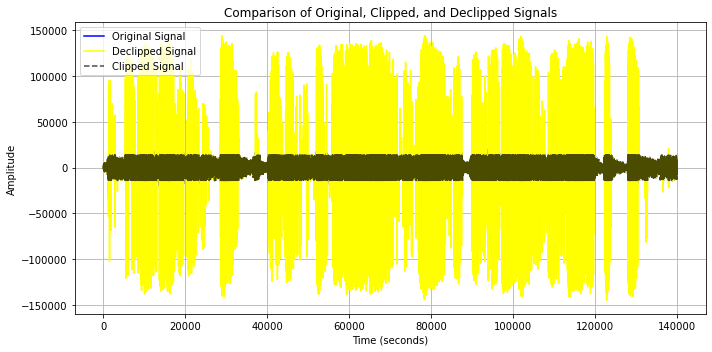

SNR of clipped signal: 15.00 dB
SNR of declipped signal: -10.72 dB
SNR gain: -25.72 dB


In [88]:
# lasso
l = evaluate(audio_data, clipped_data, audio_declipped_lasso ,clipping_masks)
print(l)

In [89]:
audio_declipped_wgl = declipping(clipped_data, clipping_masks, clip_threshold, shrinkage= wgl)

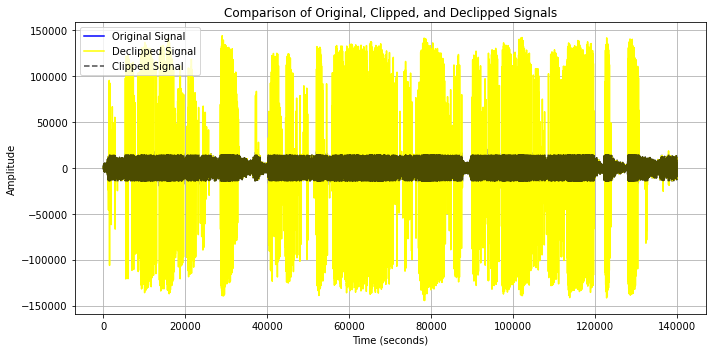

SNR of clipped signal: 15.00 dB
SNR of declipped signal: -10.63 dB
SNR gain: -25.63 dB


In [90]:
w = evaluate(audio_data, clipped_data, audio_declipped_wgl ,clipping_masks )
print(w)

In [91]:
audio_declipped_ew = declipping(clipped_data, clipping_masks, clip_threshold, shrinkage= ew)

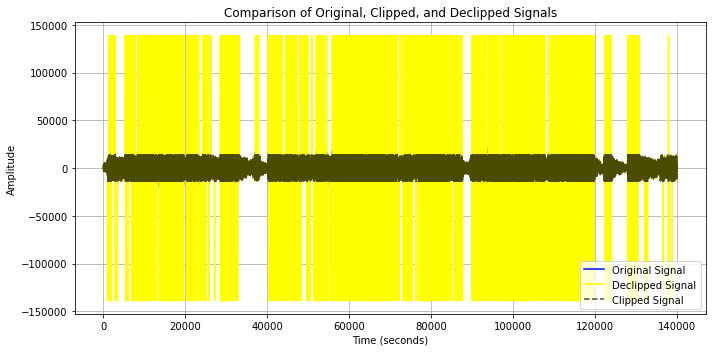

SNR of clipped signal: 15.00 dB
SNR of declipped signal: -12.71 dB
SNR gain: -27.71 dB


In [92]:
e = evaluate(audio_data, clipped_data, audio_declipped_ew ,clipping_masks )
print(e)

In [93]:
audio_declipped_pew = declipping(clipped_data, clipping_masks, clip_threshold, shrinkage= pew)

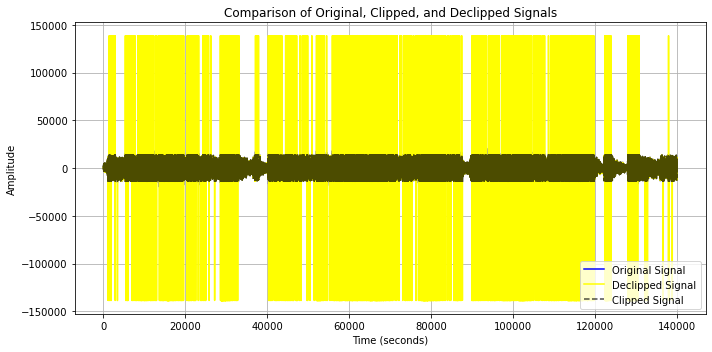

SNR of clipped signal: 15.00 dB
SNR of declipped signal: -12.71 dB
SNR gain: -27.71 dB


In [94]:
p = evaluate(audio_data, clipped_data, audio_declipped_pew ,clipping_masks )
print(p)

We can see that the operators seem to perform terribly. However, this was shown to be fixed by picking a bigger value for lambda, by testing, we saw that the 4 threhsolding methods worked well for the algorithm (specially PEW and EW). The best value we found for the initial lambda value was 10:

In [95]:
lambdas = np.logspace(10, -4, 10)
print (lambdas)

[1.00000000e+10 2.78255940e+08 7.74263683e+06 2.15443469e+05
 5.99484250e+03 1.66810054e+02 4.64158883e+00 1.29154967e-01
 3.59381366e-03 1.00000000e-04]


In [96]:
audio_declipped_lasso = declipping(clipped_data, clipping_masks, clip_threshold, lambda_config=lambdas)

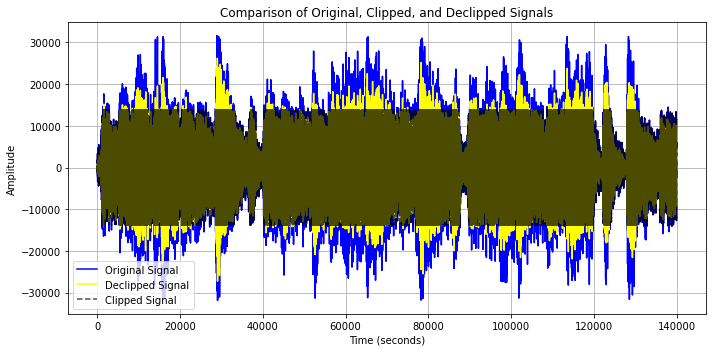

SNR of clipped signal: 15.00 dB
SNR of declipped signal: 12.37 dB
SNR gain: -2.63 dB


In [97]:
l = evaluate(audio_data, clipped_data, audio_declipped_lasso ,clipping_masks )
print(l)

In [98]:
audio_declipped_wgl = declipping(clipped_data, clipping_masks, clip_threshold, shrinkage= wgl, lambda_config=lambdas)

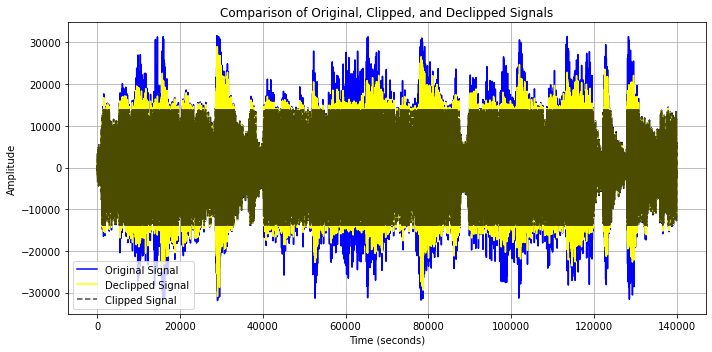

SNR of clipped signal: 15.00 dB
SNR of declipped signal: 19.15 dB
SNR gain: 4.15 dB


In [99]:
w = evaluate(audio_data, clipped_data, audio_declipped_wgl ,clipping_masks )
print(w)

In [100]:
audio_declipped_ew = declipping(clipped_data, clipping_masks, clip_threshold, shrinkage= ew, lambda_config=lambdas)

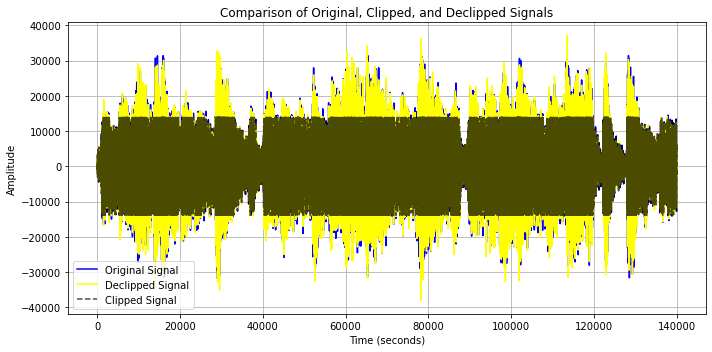

SNR of clipped signal: 15.00 dB
SNR of declipped signal: 18.99 dB
SNR gain: 3.99 dB


In [102]:
e = evaluate(audio_data, clipped_data, audio_declipped_ew ,clipping_masks)
print(e)

In [103]:
audio_declipped_pew = declipping(clipped_data, clipping_masks, clip_threshold, shrinkage= pew, lambda_config=lambdas)

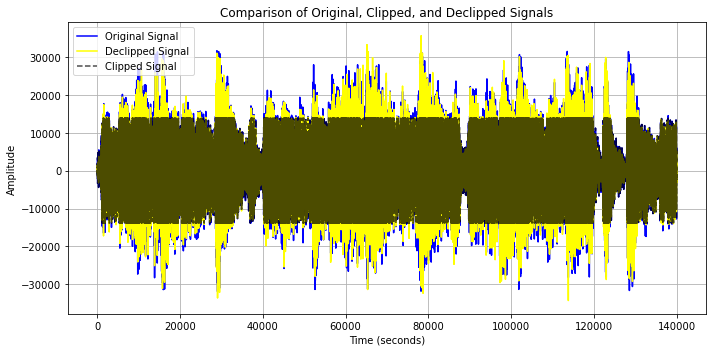

SNR of clipped signal: 15.00 dB
SNR of declipped signal: 17.10 dB
SNR gain: 2.10 dB


In [104]:
p = evaluate(audio_data, clipped_data, audio_declipped_pew ,clipping_masks )
print(p)

When utilizing lambda equal to 10, both `EW` and `PEW` demonstrate good performance, adeptly reconstructing the original signal. In our previous trials, we employed a neighborhood size of 7, but we now expand our investigation by adjusting the neighborhood of size 3 and 15. Although the literature suggests that a neighborhood size of 5 or 7 is optimal for audio signals comprising instruments, we want to explore the potential variations in results that may arise from experimenting with both larger and smaller neighborhood sizes.

Size 15

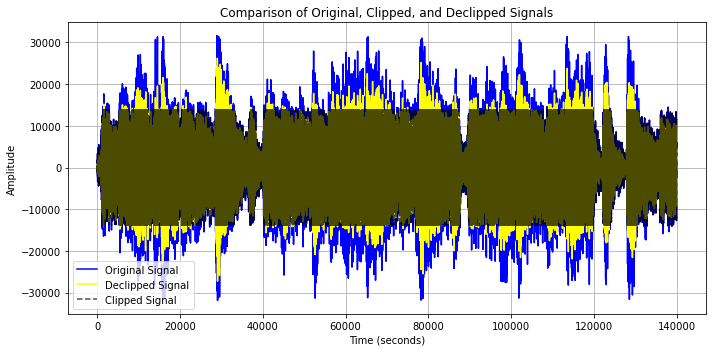

SNR of clipped signal: 15.00 dB
SNR of declipped signal: 12.37 dB
SNR gain: -2.63 dB


In [114]:
audio_declipped_n_lasso = declipping(clipped_data, clipping_masks, clip_threshold, lambda_config=lambdas, n_size=15)
l = evaluate(audio_data, clipped_data, audio_declipped_n_lasso  ,clipping_masks)
print(l)

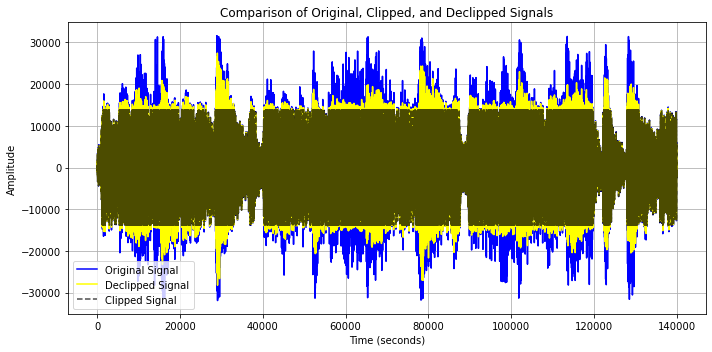

SNR of clipped signal: 15.00 dB
SNR of declipped signal: 17.74 dB
SNR gain: 2.74 dB


In [115]:
audio_declipped_n_wgl = declipping(clipped_data, clipping_masks, clip_threshold, lambda_config=lambdas, n_size=15, shrinkage=wgl)
e = evaluate(audio_data, clipped_data, audio_declipped_n_wgl  ,clipping_masks)
print(e)

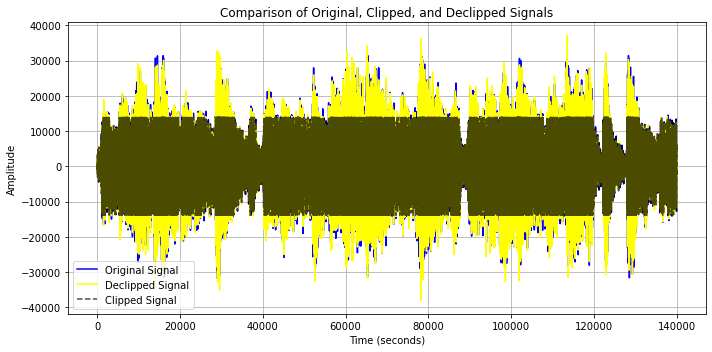

SNR of clipped signal: 15.00 dB
SNR of declipped signal: 18.99 dB
SNR gain: 3.99 dB


In [116]:
audio_declipped_n_ew = declipping(clipped_data, clipping_masks, clip_threshold, lambda_config=lambdas, n_size=15, shrinkage=ew)
e = evaluate(audio_data, clipped_data, audio_declipped_n_ew  ,clipping_masks)
print(e)

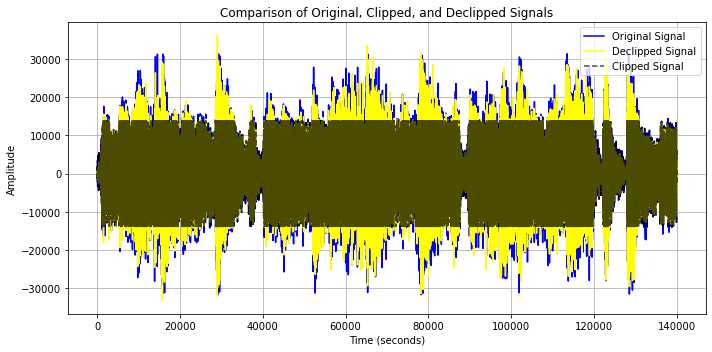

SNR of clipped signal: 15.00 dB
SNR of declipped signal: 16.01 dB
SNR gain: 1.01 dB


In [117]:
audio_declipped_n_pew = declipping(clipped_data, clipping_masks, clip_threshold, lambda_config=lambdas, n_size=15, shrinkage=pew)
e = evaluate(audio_data, clipped_data, audio_declipped_n_pew  ,clipping_masks)
print(e)

Size 3

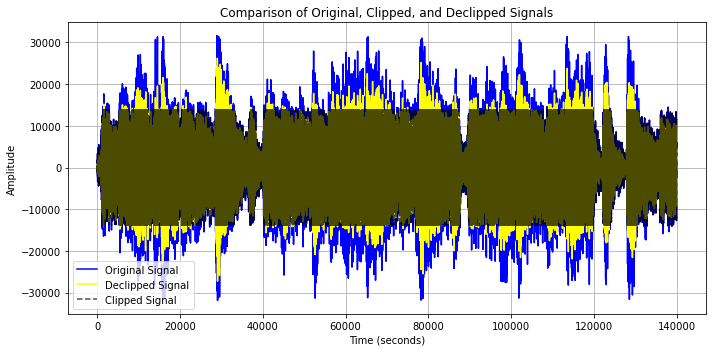

SNR of clipped signal: 15.00 dB
SNR of declipped signal: 12.37 dB
SNR gain: -2.63 dB


In [118]:
audio_declipped_n_lasso = declipping(clipped_data, clipping_masks, clip_threshold, lambda_config=lambdas, n_size=3)
l = evaluate(audio_data, clipped_data, audio_declipped_n_lasso  ,clipping_masks)
print(l)

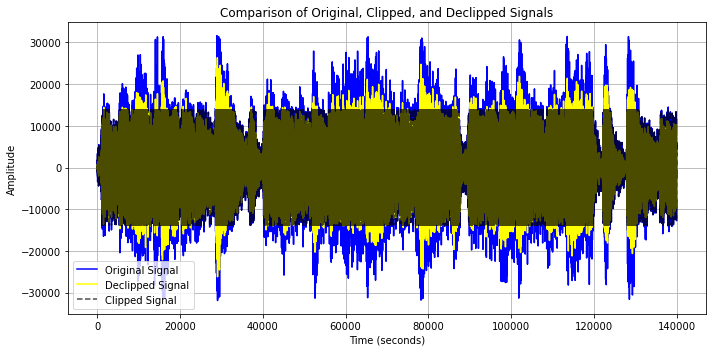

SNR of clipped signal: 15.00 dB
SNR of declipped signal: 11.74 dB
SNR gain: -3.26 dB


In [119]:
audio_declipped_n_wgl = declipping(clipped_data, clipping_masks, clip_threshold, lambda_config=lambdas, n_size=3, shrinkage=wgl)
e = evaluate(audio_data, clipped_data, audio_declipped_n_wgl  ,clipping_masks)
print(e)

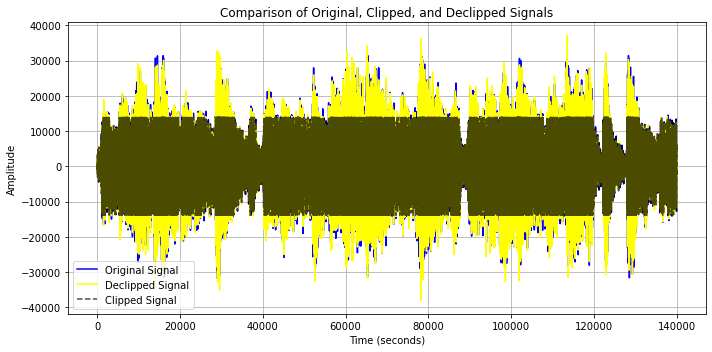

SNR of clipped signal: 15.00 dB
SNR of declipped signal: 18.99 dB
SNR gain: 3.99 dB


In [120]:
audio_declipped_n_ew = declipping(clipped_data, clipping_masks, clip_threshold, lambda_config=lambdas, n_size=3, shrinkage=ew)
e = evaluate(audio_data, clipped_data, audio_declipped_n_ew  ,clipping_masks)
print(e)

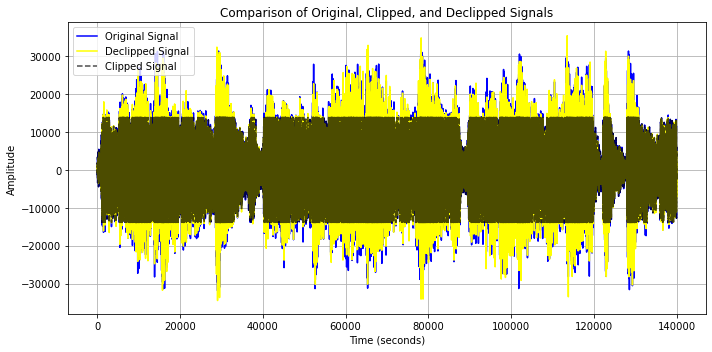

SNR of clipped signal: 15.00 dB
SNR of declipped signal: 18.18 dB
SNR gain: 3.18 dB


In [121]:
audio_declipped_n_pew = declipping(clipped_data, clipping_masks, clip_threshold, lambda_config=lambdas, n_size=3, shrinkage=pew)
e = evaluate(audio_data, clipped_data, audio_declipped_n_pew  ,clipping_masks)
print(e)

We found out that a bigger neighborhood size of 15 makes the pew method work a little better, but the change is small. On the other hand, a smaller neighborhood size of 3 makes it work worse.